In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


In [7]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device is available.")
else:
    device = torch.device("cpu")
    print("CUDA device not found. Using CPU.")

print(f"Using device: {device}")


CUDA device not found. Using CPU.
Using device: cpu


torch.Size([250, 250, 3])


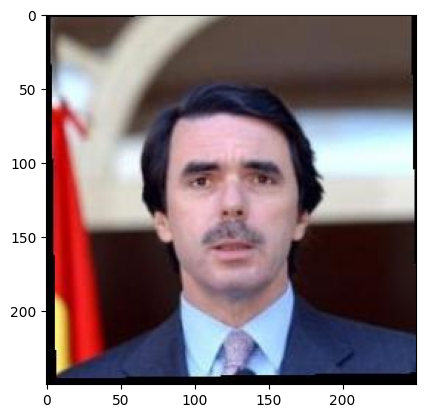

In [8]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

**Applications**

**AutoEncoders**:

**Data Denoising:** AEs are often used for denoising data, i.e., learning to ignore "noise" in the input data and reconstruct the "clean" input.

**Dimensionality Reduction:** Similar to PCA, AEs can reduce the dimensionality of data for tasks like visualization.

**Feature Extraction:** AEs can learn to encode useful features in their hidden layers.

**Variational AutoEncoders:**

**Generative Modeling:** VAEs are generative models, meaning they can generate new data instances that are similar to the training data.

**Data Imputation:** VAEs can be used for data imputation, where they generate parts of data instances that are missing.

**Anomaly Detection:** By learning the distribution of normal data, VAEs can be used to identify data points that do not fit this distribution.

**Architecture**

**AutoEncoders**:

**Encoder-Decoder Structure:** AEs consist of two main components: an encoder that compresses the input into a lower-dimensional latent space, and a decoder that reconstructs the input from this latent representation.

**Deterministic:** The process in AEs is deterministic, meaning that a given input will always produce the same encoded representation.

**Variational AutoEncoders:**

**Probabilistic Nature:** VAEs introduce a probabilistic approach. The encoder in a VAE maps inputs into a distribution over the latent space.

**Sampling:** The VAE decoder reconstructs inputs by sampling from the latent space distribution, adding a generative aspect to the model.

**Stochasticity:** This sampling process introduces randomness into the VAE, meaning the same input can yield different encodings.

**Loss Function**

**AutoEncoders:**

**Reconstruction Loss:** The loss function in an AE is typically a reconstruction loss, which measures how well the decoded output matches the original input.

**Simple Error Measurement:** This can be a simple mean squared error (MSE) or binary cross-entropy, depending on the nature of the input.

**Variational AutoEncoders:**

**Reconstruction Loss + KL Divergence:** The loss function in VAEs is a combination of reconstruction loss and the Kullback-Leibler (KL) divergence.

**Regularization by KL Divergence:** The KL divergence is a measure of how one probability distribution diverges from a second, expected probability distribution. In VAEs, it acts as a regularizer, enforcing the latent space to approximate a prior
distribution (usually a Gaussian).

**Balancing Act:** The total loss is a balance between the reconstruction accuracy and the enforcement of a smooth and continuous latent space.

In summary, while both AutoEncoders and Variational AutoEncoders have encoder-decoder architectures, VAEs incorporate a probabilistic approach and a more complex loss function, making them suitable for generative tasks. Autoencoders, being deterministic, are more suited for tasks like denoising and dimensionality reduction.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()

        # Encoder layers
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [batch, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [batch, 128, 8, 8]
            nn.ReLU(),
            nn.Flatten(),  # [batch, 128 * 8 * 8]
        )
        self.fc_mean = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        # Decoder layers
        self.fc_decoder = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [batch, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # [batch, 3, 64, 64]
            nn.Sigmoid(),  # Ensure the output values are in the range [0, 1]
        )

    def encode(self, x):
        x = self.encoder_conv(x)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def decode(self, z):
        z = self.fc_decoder(z)
        z = z.view(-1, 128, 8, 8)
        return self.decoder_conv(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [10]:
# Create an instance of the model
latent_dim = 20  # Assuming we are using a latent dimension of 20
conv_vae_model = ConvVAE(latent_dim=latent_dim)

In [11]:
# Print the model to check the architecture
print(conv_vae_model)

ConvVAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mean): Linear(in_features=8192, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=8192, out_features=20, bias=True)
  (fc_decoder): Linear(in_features=20, out_features=8192, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)


In [12]:
# # Assuming you have an image file named 'sample_image.jpg'
# image_path = '/content/lfw/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg'

In [13]:
from torchvision import transforms
from PIL import Image

# Path to an image file
image_path = '/content/lfw/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg'

# Define the transformations to preprocess the image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to the size required by the model
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

# Load the image using PIL, make sure to open it in RGB mode
image = Image.open(image_path).convert('RGB')

# Apply the transformations to the image
image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension with unsqueeze

# Print the shape of the input image tensor
print("Input image shape:", image_tensor.shape)

# Instantiate the VAE model with the appropriate latent_dim
latent_dim = 20  # Assuming a latent space dimension of 20
model = ConvVAE(latent_dim=latent_dim)

# Pass the image tensor through the VAE
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients for inference
    output_reconstructed, mean, logvar = model(image_tensor)

# Print the shape of the encoder's output
print("Mean shape:", mean.shape)
print("LogVar shape:", logvar.shape)

# Generate a new sample in the latent space
sampled_latent = model.reparameterize(mean, logvar)

# Use the decode method to create a new image from the sampled latent vector
generated_image = model.decode(sampled_latent)

# Print the shape of the decoder's output
print("Generated image shape:", generated_image.shape)



Input image shape: torch.Size([1, 3, 64, 64])
Mean shape: torch.Size([1, 20])
LogVar shape: torch.Size([1, 20])
Generated image shape: torch.Size([1, 3, 64, 64])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [14]:
# Assuming 'model' refers to an instance of the ConvVAE class
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total number of parameters in the model',total_params)

Total number of parameters in the model 830827


In [15]:
import torch.optim as optim

# Assuming conv_vae_model is an instance of your ConvVAE class
optimizer = optim.Adam(conv_vae_model.parameters(), lr=1e-3)


In [16]:
def vae_loss(reconstructed_x, original_x, mean, logvar):
    # Reconstruction loss (use MSE or BCE depending on the final layer activation)
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x.view(-1, 3*64*64), original_x.view(-1, 3*64*64), reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return reconstruction_loss + kl_divergence

**Reconstruction Loss:**

Minimizing this loss leads to a decoder that can accurately reconstruct data from the latent representations. It ensures that the latent space preserves as much information from the input data as possible.

**Kullback-Leibler Divergence Loss (KL Divergence):**

Minimizing the KL divergence encourages the encoder to distribute the encoded representations in a manner that closely resembles a standard normal distribution. This regularization helps in generalizing the encoder and avoids overfitting to the training data. It also ensures that the latent space has good properties for generating new samples, like continuity and completeness.

In summary, the reconstruction loss in a VAE ensures that the model can effectively reconstruct input data, while the KL divergence loss regularizes the latent space, encouraging the encoder to learn useful and generalizable latent representations. The combination of these two losses allows VAEs to not only learn efficient encodings of the data but also to generate new data points that are similar to the original dataset.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [17]:
# Number of training epochs
num_epochs = 10

# Set the desired dimensions for resizing
desired_height = 64  # 64x64 image
desired_width = 64

# Training loop
for epoch in range(num_epochs):
    conv_vae_model.train()  # Set the model to training mode
    total_loss_epoch = 0

    for batch_data, _ in dataloader:
        # Resize images to a consistent size, retain the color channels
        batch_data_resized = F.interpolate(batch_data, size=(desired_height, desired_width), mode='bilinear')

        # Forward pass through the VAE model
        output_reconstructed, mean, logvar = conv_vae_model(batch_data_resized)

        # Prepare target data by resizing
        target_resized = F.interpolate(batch_data, size=(desired_height, desired_width), mode='bilinear')

        # Zero the gradients before backward pass
        optimizer.zero_grad()

        # Calculate the loss
        loss = vae_loss(output_reconstructed, target_resized, mean, logvar)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss for this batch
        total_loss_epoch += loss.item()

    # Calculate the average loss for the epoch
    average_loss_epoch = total_loss_epoch / len(dataloader.dataset)

    # Report the loss at the end of each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss_epoch}")


Epoch [1/10], Loss: 6854.673882866208
Epoch [2/10], Loss: 6501.310469115925
Epoch [3/10], Loss: 6465.252111741709
Epoch [4/10], Loss: 6445.339957363829
Epoch [5/10], Loss: 6431.43526313553
Epoch [6/10], Loss: 6407.908526998187
Epoch [7/10], Loss: 6392.037892130014
Epoch [8/10], Loss: 6383.447266657853
Epoch [9/10], Loss: 6376.295205909571
Epoch [10/10], Loss: 6371.1873618928


If the loss of model is not decreasing during training, it typically indicates that the model is not learning effectively from the data. There are several steps we can take to troubleshoot and potentially resolve this issue:

**Check Data Preprocessing:**

Ensure that the input data is correctly preprocessed and normalized.
Verify that the data is correctly labeled and that there are no inconsistencies or errors in the dataset.

**Learning Rate Adjustment:**

If the learning rate is too high, the model might overshoot minima; if it's too low, learning could be too slow. Try adjusting the learning rate.
Consider using learning rate schedulers that adjust the rate during training.

**Model Architecture:**

Review the model architecture. For instance, a model might be too simple (underfitting) or too complex (overfitting).
Add or reduce layers or change their types and parameters (like the number of neurons in a dense layer, the number of filters in a convolutional layer, etc.).

**Regularization:**

Implement or adjust regularization techniques like dropout, L1/L2 regularization if your model is overfitting.
Batch normalization can also sometimes help in stabilizing and speeding up training.

**Optimizer:**

Experiment with different optimizers (e.g., Adam, RMSprop, SGD) and their parameters.
Ensure the optimizer is appropriate for the type of model and problem.

**Loss Function:**

Make sure you're using the correct loss function for your specific problem (e.g., cross-entropy for classification, mean squared error for regression).
Consider using a different loss function if the current one is not effective.

**Batch Size:**

Experiment with different batch sizes. Smaller batches can offer more frequent updates, but larger batches provide better estimates of the gradient.

**Data Augmentation:**

If applicable, use data augmentation to increase the diversity of the training dataset, which can help in generalization.
Initialization:

Experiment with different weight initialization methods. Poor initialization can hinder the learning of the model.

**Training Duration:**

Increase the number of epochs or iterations. Sometimes, the model might need more time to learn effectively.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

In [18]:
# Save the trained model
model_path = 'conv_vae_model.pth'
torch.save(conv_vae_model.state_dict(), model_path)

In [19]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


model_path = 'conv_vae_model.pth'
try:
    conv_vae_model.load_state_dict(torch.load(model_path))
    conv_vae_model.eval()
except Exception as e:
    print(f"Error loading the model: {e}")

# Choose a random image from the dataset
random_index = random.randint(0, len(dataloader.dataset) - 1)
random_image, _ = dataloader.dataset[random_index]

# Convert the tensor to a PIL Image and preprocess it
random_image_pil = transforms.ToPILImage()(random_image)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor()  # Keep RGB channels
])
# Ensure the image tensor is of the correct shape for ConvVAE
random_image_tensor = transform(random_image_pil).unsqueeze(0)

# Forward pass through the first layer (encoder)
try:
    mean, logvar = conv_vae_model.encode(random_image_tensor)
except Exception as e:
    print(f"Error during forward pass through the first layer: {e}")




In [21]:
# Define the number of samples and latent dimension
num_samples = 8  # For example, generate 8 images
latent_dim = 20  # This should match the latent dimension size of your ConvVAE model

# Ensure that random_image is of shape [1, 3, H, W]
if len(random_image.shape) == 3:
    random_image_resized = F.interpolate(random_image.unsqueeze(0), size=(64, 64), mode='bilinear')
else:
    random_image_resized = F.interpolate(random_image, size=(64, 64), mode='bilinear')

# Generate random latent vectors
random_latent_vectors = torch.randn(num_samples, latent_dim)

# Generate images from the latent vectors
with torch.no_grad():
    conv_vae_model.eval()  # Ensure the model is in evaluation mode
    generated_images = conv_vae_model.decode(random_latent_vectors).cpu()

# Clamp the values of the generated images to the range [0, 1]
generated_images = torch.clamp(generated_images, 0, 1)

# Concatenate with random_image for visualization
concatenated_images = torch.cat([random_image_resized, generated_images], dim=0)


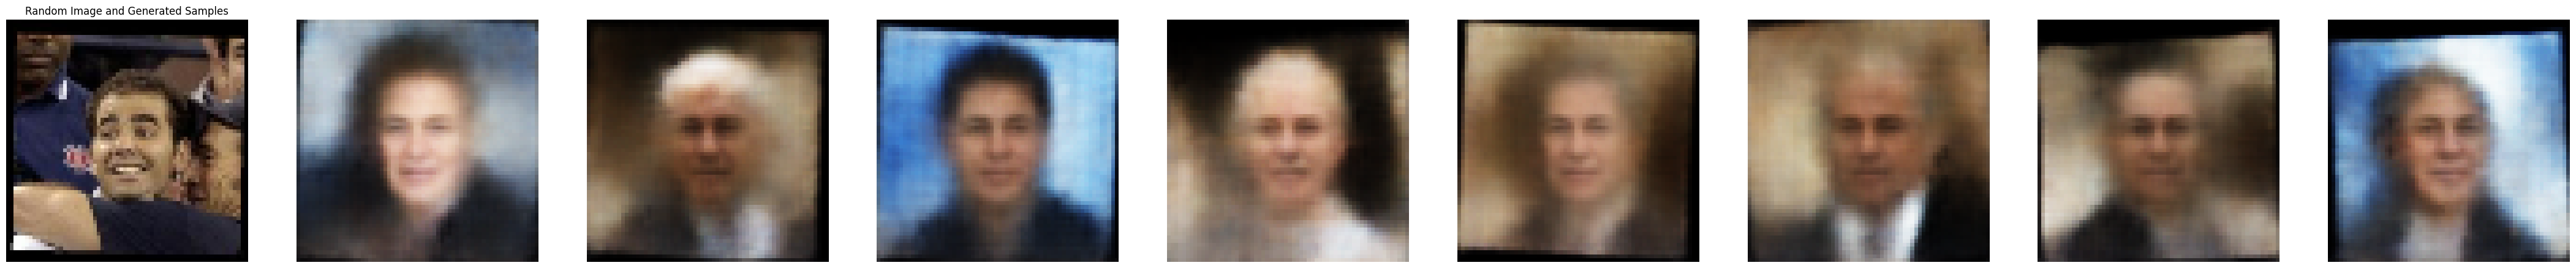

In [22]:
import matplotlib.pyplot as plt

def plot_images_side_by_side(images, title, image_size=(6, 6)):
    # Set the number of images to display
    num_images = images.size(0)

    # Create a larger figure to hold the subplots
    plt.figure(figsize=(image_size[0] * num_images, image_size[1]))

    # Loop through and plot each image in a subplot
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(title if i == 0 else "")
        plt.axis('off')

    plt.show()

# Your existing code to generate and concatenate images
# ...

# Plotting the images side by side
plot_images_side_by_side(concatenated_images, "Random Image and Generated Samples", image_size=(6, 6))
